In [82]:
import torch 
import torch.nn as nn
from train import *
import os 
from pathlib import Path
from dynRNN.task import *
import matplotlib.pyplot as plt
from tqdm import trange

CONFIG = {
    'mem_size' : 16,
    'better_init_GRU': 'BiGRU',
    'device': 'cuda'
}

task = FreqDiscr

# run_name = 'eternal-shape-1057_24cvlfzn' #SequenceIngestion
# run_name = 'giddy-forest-1008_e3g95sfc' #FreqDiscr 2BiGRU
# run_name = 'dutiful-dew-1005_q39f9tkl' #FreqDiscr BiGRU
# run_name = 'gallant-grass-1069_8d6ohr4h' #FreqDiscr GRU 16
run_name = 'fast-valley-1066_bs7kmjjh' #FreqDiscr 2BiGRU 16
run_name = 'fast-valley-1066_bs7kmjjh' #FreqDiscr 2BiGRU 16
# run_name = 'rose-voice-1033_ks8ntymw' #IntervalComparisonTask
# run_name = 'ancient-armadillo-1025_e8n4nynj' #IntervalProductionTask

SCRATCH = os.environ.get('SCRATCH', '.')
PATH = Path(SCRATCH) / f'GRU_dyn/Cpy1in/runs/{run_name}/checkpoint.pth'

rnn, decoder = build(**CONFIG)
mod = torch.load(PATH)

rnn.load_state_dict(mod['rnn_check'])
decoder.load_state_dict(mod['decoder_check'])

rnn.eval()
decoder.eval()

Linear(in_features=16, out_features=1, bias=True)

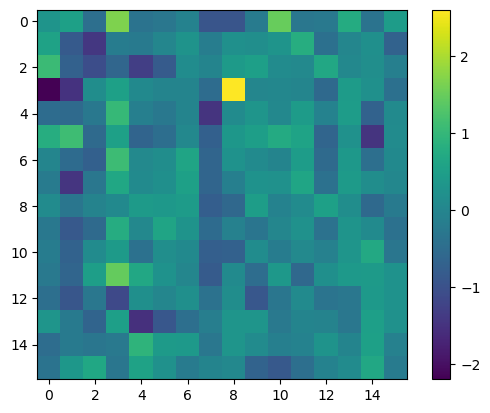

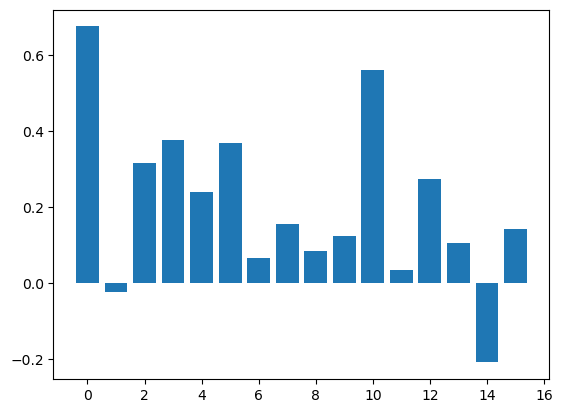

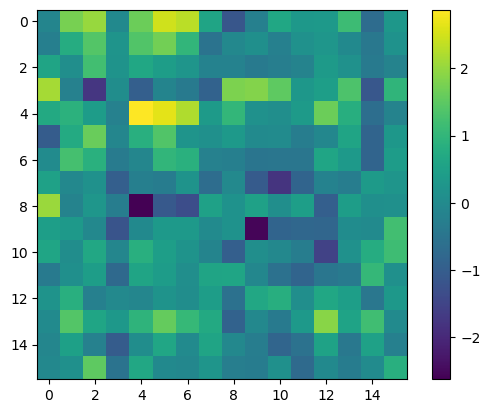

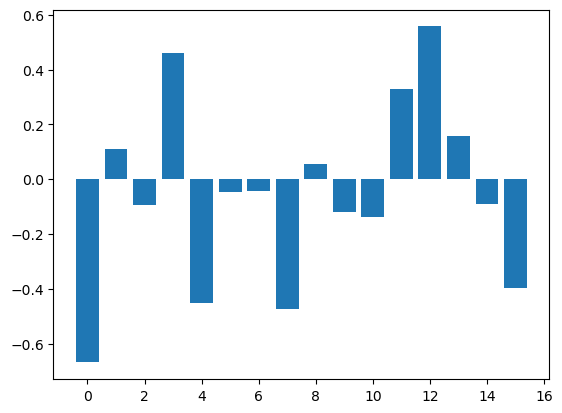

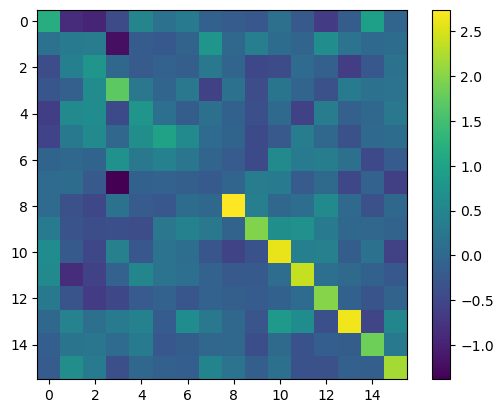

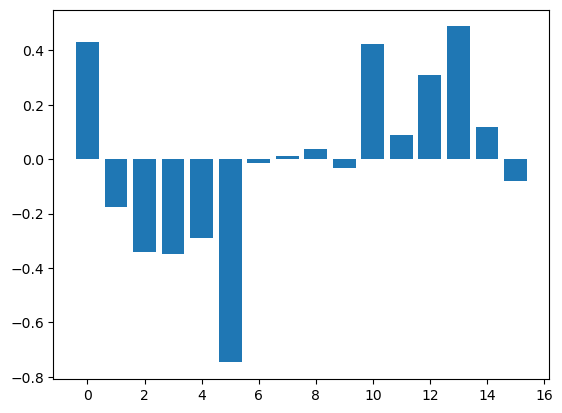

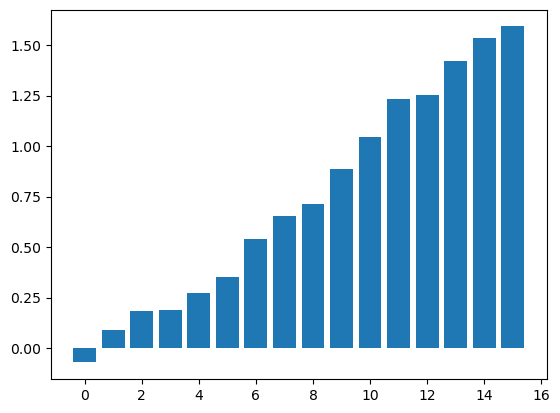

In [83]:
with torch.no_grad():
    for i in range(3):
        plt.imshow(rnn.weight_hh_l0[i*CONFIG['mem_size']:(i+1)*CONFIG['mem_size']].cpu(), interpolation='none')
        plt.colorbar()
        plt.show()
        plt.bar(range(CONFIG['mem_size']), rnn.bias_hh_l0[i*CONFIG['mem_size']:(i+1)*CONFIG['mem_size']].cpu())
        plt.show()

    gate = torch.sigmoid(rnn.bias_hh_l0[CONFIG['mem_size']:2*CONFIG['mem_size']] +\
                         rnn.bias_ih_l0[CONFIG['mem_size']:2*CONFIG['mem_size']])

    bif_param = rnn.weight_hh_l0[2*CONFIG['mem_size']:3*CONFIG['mem_size']][range(CONFIG['mem_size']),range(CONFIG['mem_size'])]

    plt.bar(range(CONFIG['mem_size']),(bif_param*gate).cpu().sort()[0])
    

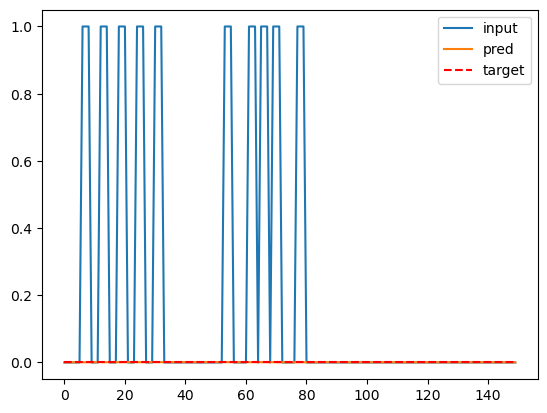

tensor([0.2408, 0.1250, 0.2997, 0.0643, 0.3013, 0.0243, 0.0529, 0.1452, 0.5781,
        0.2422, 0.7825, 0.3250, 0.1330, 0.0068, 0.0940, 0.2560],
       device='cuda:0')


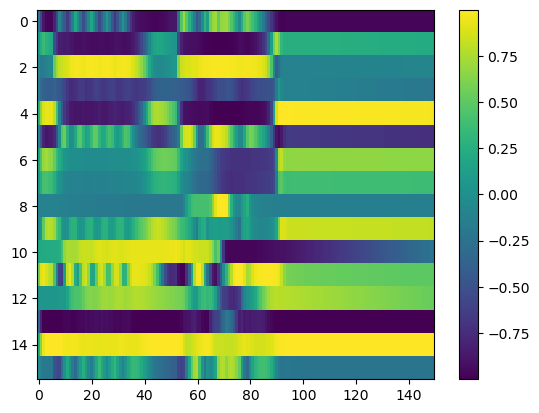

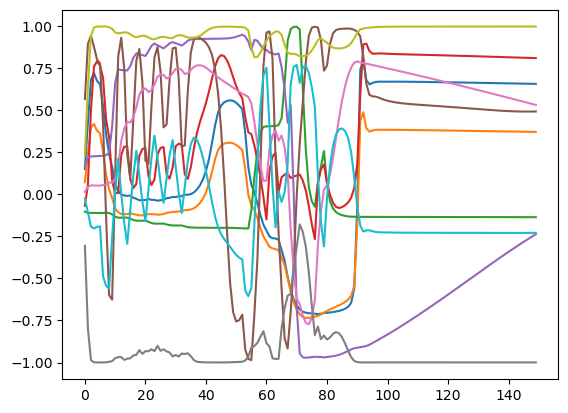

In [87]:
d,l = task.get_batch(1)

delay = 0
with torch.no_grad():
    d = d.cuda()
    d = nn.functional.pad(d,(0,0,0,delay))
    l = nn.functional.pad(l,(0,0,0,delay))
    out_t = rnn(d)[0]
    traj = decoder(out_t)
    FreqDiscr.show_pred(traj.squeeze().cpu(),l[0],d.squeeze().cpu())
    plt.show()
    vec = torch.cat((d[0].T,out_t[0].T),dim=0)
    cc = torch.corrcoef(vec)[:,0]
    print(vec[1:].var(dim=1))
    idx = torch.argsort(cc.abs(), descending=True)
    plt.imshow(vec[idx[1:]].cpu(), interpolation='none', aspect='auto')
    plt.colorbar()
    plt.show()
    for t in vec[idx[-10:]]:
        plt.plot(t.cpu())
    plt.show()

In [88]:
class LayerNorm(nn.Module):
    def __init__(self, dim, eps = 1e-5):
        super().__init__()
        self.dim = dim
        self.eps = eps

    def forward(self, x):
        var, mu = torch.var_mean(x, dim = self.dim, keepdim = True, unbiased = True)
        # print(var, mu)
        return (x - mu)/(var + self.eps).sqrt()
    
class LowDimProj(nn.Module):
    def __init__(self, high_sz, proj_sz, hidden):
        super().__init__()
        self.act = nn.Identity()
        self.encoder = nn.ModuleList([nn.Linear(i,j) for i,j in zip((high_sz,)+hidden, hidden+(proj_sz,))])
        hidden = tuple(reversed(hidden))
        self.decoder = nn.ModuleList([nn.Linear(i,j) for i,j in zip((proj_sz,)+hidden, hidden+(high_sz,))])
        self.norm = LayerNorm(-1)
        
    def encode(self,x):
        for e in self.encoder[:-1]:
            x = self.act(e(self.norm(x)))
        
        return self.encoder[-1](x)
    
    def decode(self,x):
        for d in self.decoder[:-1]:
            x = self.act(d(self.norm(x)))
        
        return self.decoder[-1](x)
    
    def loss(self, x, w=1e-3):
        Loss = nn.MSELoss()
        z = self.encode(x)
        
        return Loss(self.decode(z),x) + w*z.norm()
            
        
trajNet = LowDimProj(16, 2, (64,32,16,8)).to(CONFIG['device'])
epoch = 2048
batch = 256
optim = torch.optim.AdamW(trajNet.parameters(), lr=1e-4, weight_decay=1e-4)
evaluate = 1024
data_eval, l_eval = task.get_batch(10)    
data_eval = data_eval.to(CONFIG['device'])
data_eval = rnn(data_eval)[0]
l_eval = l_eval.to(CONFIG['device'])


0.5646756887435913:   0%|          | 0/2048 [00:00<?, ?it/s]

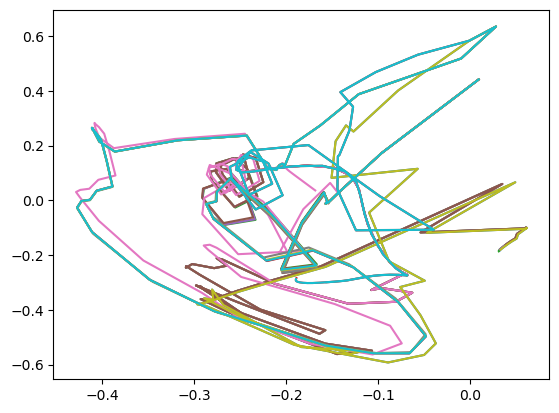

0.1451365053653717:  50%|████▉     | 1023/2048 [01:01<01:01, 16.71it/s] 

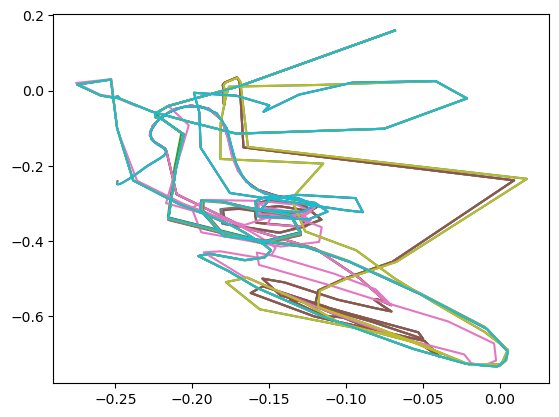

0.13497449457645416: 100%|██████████| 2048/2048 [02:02<00:00, 16.72it/s]


In [89]:
# for e in (pbar := trange(epoch)):
#     trajNet.train()
#     with torch.no_grad():
#         data = CopyFirstInput.get_batch(batch, 100)

#         traj = rnn(data.to(CONFIG['device']))[0]
    
#     l = trajNet.loss(traj,w=0)
#     pbar.set_description(str(l.item()))
#     l.backward()
#     optim.step()
#     optim.zero_grad()
    
#     if (e % evaluate) == 0:
#         trajNet.eval()
#         with torch.no_grad():
#             proj = trajNet.encode(data_eval)
#             for p in proj:
#                 plt.plot(p[:,0].cpu(),p[:,1].cpu())
#             plt.show()

for e in (pbar := trange(epoch)):
    trajNet.train()
    with torch.no_grad():
        data,_ = task.get_batch(batch)

        traj = rnn(data.to(CONFIG['device']))[0]
        
    l = trajNet.loss(traj,w=0)
    pbar.set_description(str(l.item()))
    l.backward()
    optim.step()
    optim.zero_grad()
    
    if (e % evaluate) == 0:
        trajNet.eval()
        with torch.no_grad():
            proj = trajNet.encode(data_eval)
            for p in proj:
                plt.plot(p[:,0].cpu(),p[:,1].cpu())
            plt.show()

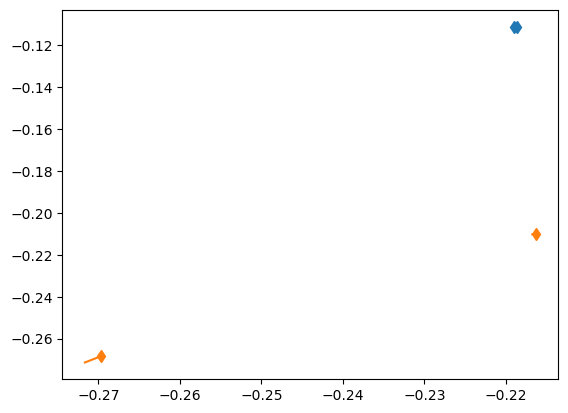

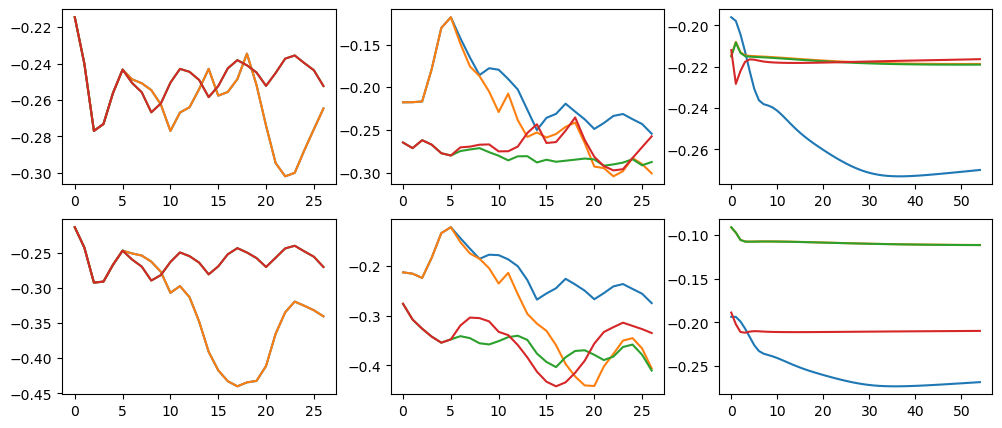

In [102]:
# data_eval = CopyFirstInput.get_batch(100, 300).to(CONFIG['device'])
# with torch.no_grad():
#     data_eval = rnn(data_eval)[0]
#     proj = data_eval#trajNet.encode(data_eval)
#     for p in proj:
#         plt.plot(p[:,0].cpu(),p[:,1].cpu())
#         plt.plot(p[-1,0].cpu(),p[-1,1].cpu(), marker='d', markersize=10)
#     plt.show()
#     for p in proj:
#         plt.plot(p[10:,0].cpu())
#     plt.show()
#     for p in proj:
#         plt.plot(p[10:,1].cpu())
#     plt.show()
    
#     x, idx = torch.sort(proj[:,0,0])
#     plt.plot(x.cpu(),proj[idx,0,1].cpu(), marker='d', markersize=10)
#     plt.show()
    
#     x, idx = torch.sort(proj[:,-1,0])
#     plt.plot(x.cpu(),proj[idx,-1,1].cpu(), marker='d', markersize=10)
#     plt.show()

data_eval,l = task.get_batch(200)
data_eval = data_eval.to(CONFIG['device'])

data_eval = torch.zeros((4,150,1))
l = torch.zeros((4,150,1))
data_eval[:2,10:10+27,0] = FreqDiscr.grouped()
data_eval[1,10+27+20:10+27*2+20,0] = FreqDiscr.grouped()
data_eval[-1,10+27+20:10+27*2+20,0] = FreqDiscr.grouped()
data_eval[-2:,10:10+27,0] = FreqDiscr.evenly()
data_eval[0,10+27+20:10+27*2+20,0] = FreqDiscr.evenly()
data_eval[-2,10+27+20:10+27*2+20,0] = FreqDiscr.evenly()
l[1:3,10+27*2+20+10:] = 1
data_eval = data_eval.to(CONFIG['device'])
# for d in data_eval:
#     plt.plot(d.cpu())
# plt.show()
see_t = 10
with torch.no_grad():
    data_eval = rnn(data_eval)[0]
    proj = trajNet.encode(data_eval)
    
    for i,p in enumerate(proj):
        col = 'C0' if l[i,-1]==1 else 'C1'
        plt.plot(p[-see_t:,0].cpu(),p[-see_t:,1].cpu(),col)
        plt.plot(p[-1,0].cpu(),p[-1,1].cpu(), f'{col}d')
    plt.show()
    
    first = [10, 10+27+20, 10+27*2+20+10]
    last = [10+27, 10+27*2+20, -1]
    k = 0
    f,ax = plt.subplots(2,3, figsize=(12,5))
    for f,e in zip(first,last):
        for i,p in enumerate(proj):
            col = 'C0' if l[i,-1]==1 else 'C1'
            ax[0,k].plot(p[f:e,0].cpu())#,col)
        for i,p in enumerate(proj):
            col = 'C0' if l[i,-1]==1 else 'C1'
            ax[1,k].plot(p[f:e,1].cpu())#,col)
        k += 1
    plt.show()
    